In [1]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from VisionUtils import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, SelectFpr, mutual_info_classif
import numpy as np
import tensorflow as tf

In [2]:
tf.enable_eager_execution()

In [3]:
feat1 = np.load("features/feat1.npy")
feat2 = np.load("features/feat2.npy")
labels = np.load("features/labels.npy")

In [31]:
def trans(feat1, feat2):
    f1 = [feat1[i1].reshape(-1,1) for i1 in range(len(feat1))]
    f2 = [feat2[i2].reshape(-1,1) for i2 in range(len(feat2))]
    cos_d = np.array([feat_distance_cosine_scalar(f1[i].T, f2[i]) for i in range(len(feat1))])
    cos_d = cos_d.reshape(-1,1)
    sqr_diff = np.power(np.abs(feat1- feat2), 2)
    rat = feat1/feat2
    data = np.hstack([cos_d, sqr_diff])
    return data

In [32]:
data = trans(feat1, feat2)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [33]:

xtrain, xtest, ytrain, ytest = train_test_split(scaled_data, labels, 
                                                shuffle = True, random_state = 42)

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.regularizers import l1, l2
he_init = tf.keras.initializers.VarianceScaling()

model = Sequential()
model.add(Dense( 128, activation = 'relu', kernel_initializer = he_init, 
                kernel_regularizer = l1(0.001), 
                #input_shape = (1,128)
               ))
model.add(Dense(32, activation = 'relu',kernel_initializer = he_init))
model.add(Dense(1, activation = "tanh", kernel_initializer = he_init))

In [70]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
mcp = ModelCheckpoint("models_chpt/best_modelD.hdf5",verbose = 1, 
                      monitor = "val_loss", save_best_only = True, save_weights_only = True)
red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor =0.5)
opt = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer = opt, loss = "binary_crossentropy", 
              metrics = ["accuracy"] )

In [71]:
bz = 1000
epochs = 400
history = model.fit(
    xtrain,
    ytrain,
    epochs = epochs,
    batch_size = bz,
    validation_data =(xtest, ytest),
    callbacks = [mcp, red_lr]
)


Train on 21450 samples, validate on 7150 samples
Epoch 1/400
 1000/21450 [>.............................] - ETA: 1s - loss: 2.9236 - acc: 0.4700
Epoch 00001: val_loss improved from inf to 0.84806, saving model to models_chpt/best_modelD.hdf5
21450/21450 [==============================] - 0s 13us/sample - loss: 1.4512 - acc: 0.6972 - val_loss: 0.8481 - val_acc: 0.8916
Epoch 2/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.8137 - acc: 0.8890
Epoch 00002: val_loss improved from 0.84806 to 0.61122, saving model to models_chpt/best_modelD.hdf5
21450/21450 [==============================] - 0s 3us/sample - loss: 0.7517 - acc: 0.8704 - val_loss: 0.6112 - val_acc: 0.8926
Epoch 3/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.6064 - acc: 0.8810
Epoch 00003: val_loss improved from 0.61122 to 0.44603, saving model to models_chpt/best_modelD.hdf5
21450/21450 [==============================] - 0s 3us/sample - loss: 0.5240 - acc: 0.8857 - val_loss: 0.4460 

Epoch 29/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3691 - acc: 0.9000
Epoch 00029: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.3918 - acc: 0.8887 - val_loss: 0.3961 - val_acc: 0.8909
Epoch 30/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3559 - acc: 0.8960
Epoch 00030: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.3832 - acc: 0.8881 - val_loss: 0.3877 - val_acc: 0.8903
Epoch 31/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.4099 - acc: 0.8720
Epoch 00031: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.3797 - acc: 0.8869 - val_loss: 0.3777 - val_acc: 0.8876
Epoch 32/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3847 - acc: 0.8840
Epoch 00032: val_loss did not improve from 0.29075
21450/21450 [==============

Epoch 59/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3545 - acc: 0.8830
Epoch 00059: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.3046 - acc: 0.8940 - val_loss: 0.3156 - val_acc: 0.8958
Epoch 60/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2814 - acc: 0.8980
Epoch 00060: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.3043 - acc: 0.8941 - val_loss: 0.3155 - val_acc: 0.8962
Epoch 61/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2797 - acc: 0.9040
Epoch 00061: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.3039 - acc: 0.8942 - val_loss: 0.3150 - val_acc: 0.8958
Epoch 62/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2893 - acc: 0.8980
Epoch 00062: val_loss did not improve from 0.29075
21450/21450 [==============

Epoch 89/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2955 - acc: 0.8960
Epoch 00089: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2984 - acc: 0.8944 - val_loss: 0.3096 - val_acc: 0.8958
Epoch 90/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2792 - acc: 0.9010
Epoch 00090: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2984 - acc: 0.8944 - val_loss: 0.3096 - val_acc: 0.8959
Epoch 91/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3303 - acc: 0.8950
Epoch 00091: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2983 - acc: 0.8945 - val_loss: 0.3095 - val_acc: 0.8958
Epoch 92/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3269 - acc: 0.8890
Epoch 00092: val_loss did not improve from 0.29075
21450/21450 [==============

Epoch 119/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2936 - acc: 0.9000
Epoch 00119: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2975 - acc: 0.8945 - val_loss: 0.3088 - val_acc: 0.8961
Epoch 120/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2956 - acc: 0.8910
Epoch 00120: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2975 - acc: 0.8945 - val_loss: 0.3088 - val_acc: 0.8961
Epoch 121/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2706 - acc: 0.8970
Epoch 00121: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2975 - acc: 0.8945 - val_loss: 0.3088 - val_acc: 0.8961
Epoch 122/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2989 - acc: 0.8980
Epoch 00122: val_loss did not improve from 0.29075
21450/21450 [==========

Epoch 149/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3173 - acc: 0.8760
Epoch 00149: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3087 - val_acc: 0.8961
Epoch 150/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3259 - acc: 0.8850
Epoch 00150: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3087 - val_acc: 0.8961
Epoch 151/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3168 - acc: 0.8870
Epoch 00151: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 152/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2735 - acc: 0.9000
Epoch 00152: val_loss did not improve from 0.29075
21450/21450 [==========

Epoch 179/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2952 - acc: 0.9060
Epoch 00179: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 180/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2563 - acc: 0.9110
Epoch 00180: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 181/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2808 - acc: 0.8910
Epoch 00181: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 182/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2954 - acc: 0.8950
Epoch 00182: val_loss did not improve from 0.29075
21450/21450 [==========

Epoch 209/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3007 - acc: 0.8820
Epoch 00209: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 210/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3007 - acc: 0.8930
Epoch 00210: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 211/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2623 - acc: 0.9200
Epoch 00211: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 212/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3094 - acc: 0.8760
Epoch 00212: val_loss did not improve from 0.29075
21450/21450 [==========

Epoch 239/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2655 - acc: 0.9030
Epoch 00239: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 240/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3406 - acc: 0.8760
Epoch 00240: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 241/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3206 - acc: 0.9010
Epoch 00241: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 242/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2949 - acc: 0.8920
Epoch 00242: val_loss did not improve from 0.29075
21450/21450 [==========

Epoch 269/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2675 - acc: 0.9020
Epoch 00269: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 270/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2710 - acc: 0.9110
Epoch 00270: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 271/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3169 - acc: 0.8840
Epoch 00271: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 272/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2831 - acc: 0.8870
Epoch 00272: val_loss did not improve from 0.29075
21450/21450 [==========

Epoch 299/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3277 - acc: 0.8950
Epoch 00299: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 300/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2878 - acc: 0.9000
Epoch 00300: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 301/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2906 - acc: 0.9170
Epoch 00301: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 302/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2932 - acc: 0.8860
Epoch 00302: val_loss did not improve from 0.29075
21450/21450 [==========

Epoch 329/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2751 - acc: 0.8890
Epoch 00329: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 330/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3106 - acc: 0.8880
Epoch 00330: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 331/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2891 - acc: 0.8890
Epoch 00331: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 332/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3123 - acc: 0.8980
Epoch 00332: val_loss did not improve from 0.29075
21450/21450 [==========

Epoch 359/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3109 - acc: 0.8970
Epoch 00359: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 360/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2901 - acc: 0.9040
Epoch 00360: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 361/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3075 - acc: 0.9090
Epoch 00361: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 362/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2861 - acc: 0.8940
Epoch 00362: val_loss did not improve from 0.29075
21450/21450 [==========

Epoch 389/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3198 - acc: 0.8890
Epoch 00389: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 390/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2547 - acc: 0.9050
Epoch 00390: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 391/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.2629 - acc: 0.9030
Epoch 00391: val_loss did not improve from 0.29075
21450/21450 [==============================] - 0s 3us/sample - loss: 0.2974 - acc: 0.8945 - val_loss: 0.3086 - val_acc: 0.8961
Epoch 392/400
 1000/21450 [>.............................] - ETA: 0s - loss: 0.3082 - acc: 0.8890
Epoch 00392: val_loss did not improve from 0.29075
21450/21450 [==========

In [65]:
model.evaluate(xtest, ytest)

7150/7150 [==============================] - 0s 20us/sample - loss: 0.2510 - acc: 0.8972


[0.2509558886331278, 0.8972028]

Text(0.5, 1.0, 'Loss Vs # of epochs')

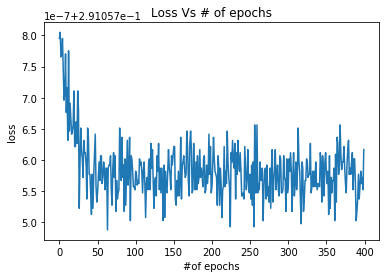

In [42]:
%matplotlib inline 
plt.plot( [i for i in range(epochs)], history.history['val_loss'], label = "validation loss")
plt.xlabel("#of epochs")
plt.ylabel("loss")
plt.title("Loss Vs # of epochs")

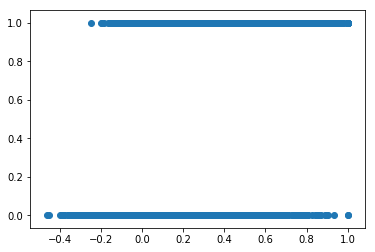

In [8]:
plt.scatter(cos_d, labels)

Text(0.5, 1.0, 'Loss Vs # of epochs')

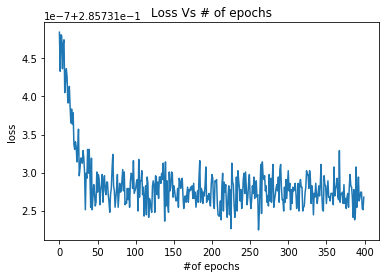

In [43]:
plt.plot([i for i in range(epochs)], history.history['loss'], label = "Train loss")
plt.xlabel("#of epochs")
plt.ylabel("loss")
plt.title("Loss Vs # of epochs")

Text(0.5, 1.0, 'Learning rate Vs # of epochs')

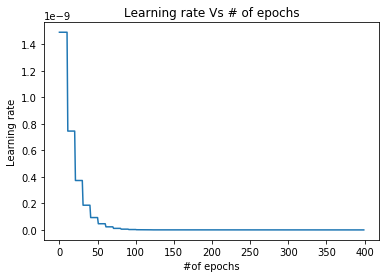

In [44]:
plt.plot([i for i in range(epochs)], history.history['lr'], label = "Train loss")
plt.xlabel("#of epochs")
plt.ylabel("Learning rate")
plt.title("Learning rate Vs # of epochs")

In [45]:
model.evaluate(xtest, ytest)

6000/6000 [==============================] - 0s 15us/sample - loss: 0.2911 - acc: 0.8828


[0.2910575838883718, 0.88283336]

In [46]:
model_best = model

In [47]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [48]:
model_best.load_weights("models_chpt/best_modelD.hdf5")

In [49]:
model_best.evaluate(xtest, ytest)

6000/6000 [==============================] - 0s 16us/sample - loss: 0.2911 - acc: 0.8828


[0.2910575842857361, 0.88283336]